## Fetching data from SKLearn

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

## Data Description

In [11]:
mnist["DESCR"]

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

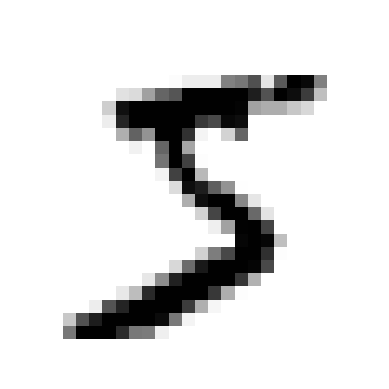

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.loc[0].array
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [18]:
y[0]

'5'

## Converting the target to integer

In [19]:
import numpy as np

y = y.astype(np.uint8)

## Splitting the data into training and testing

In [20]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

### Stochastic Gradient Descent (SGD) Classifier

In [22]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [27]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train.values, y_train_5)

SGDClassifier(random_state=42)

In [28]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [29]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train.values, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

#### Accuracy is not always a good measure for classifiers (especially when dealing with skewed datasets)
Guessing always not 5 gives as an accuracy of 90% (as only 10% of the data is 5)

In [30]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [31]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train.values, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [32]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train.values, y_train_5, cv=3)

In [33]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

#### Perfect Confusion Matrix - NOT POSSIBLE

In [36]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

In [39]:
from sklearn.metrics import precision_score, recall_score

print("Precision: ", precision_score(y_train_5, y_train_pred))
print("Recall: ", recall_score(y_train_5, y_train_pred))

Precision:  0.8370879772350012
Recall:  0.6511713705958311


#### F1 Score

In [40]:
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(y_train_5, y_train_pred))

F1 Score:  0.7325171197343847


### Precision/Recall Tradeoff

In [41]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

#### Setting a threshold equal to the one used by the SGDClassifier

In [43]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

#### Highering the threshold

In [44]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

#### Choosing the threshold

In [45]:
y_scores = cross_val_predict(sgd_clf, X_train.values, y_train_5, cv=3, method="decision_function")

In [46]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

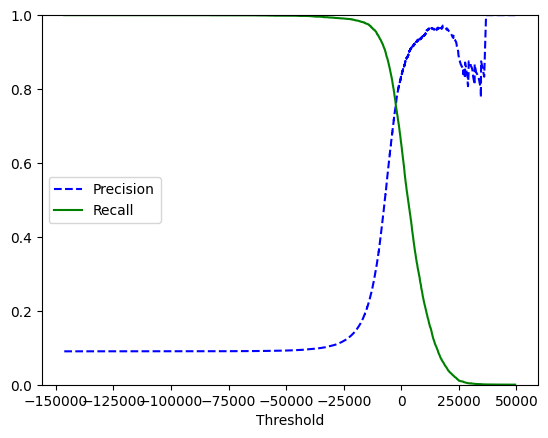

In [47]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

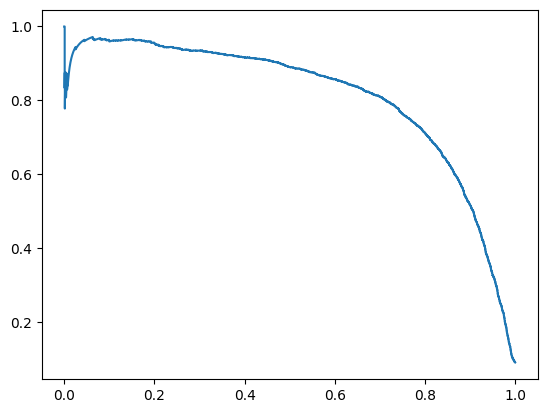

In [48]:
plt.plot(recalls, precisions)

In [51]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [52]:
print("Precision: ", precision_score(y_train_5, y_train_pred_90))
print("Recall: ", recall_score(y_train_5, y_train_pred_90))

Precision:  0.9000345901072293
Recall:  0.4799852425751706


### ROC Curve

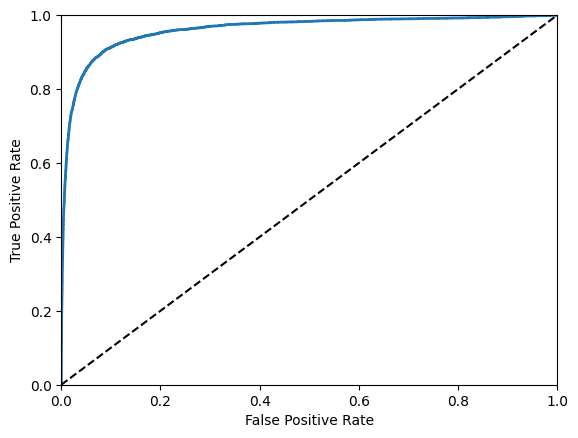

In [53]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [54]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

### Random Forest Classifier

In [55]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train.values, y_train_5, cv=3, method="predict_proba")

In [56]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [57]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

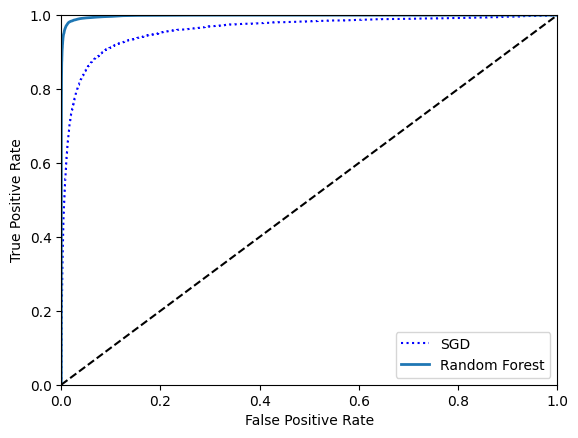

In [61]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [62]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [63]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train.values, y_train_5, cv=3)

print("Precision: ", precision_score(y_train_5, y_train_pred_forest))
print("Recall: ", recall_score(y_train_5, y_train_pred_forest))

Precision:  0.9905083315756169
Recall:  0.8662608374838591


In [67]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_forest)

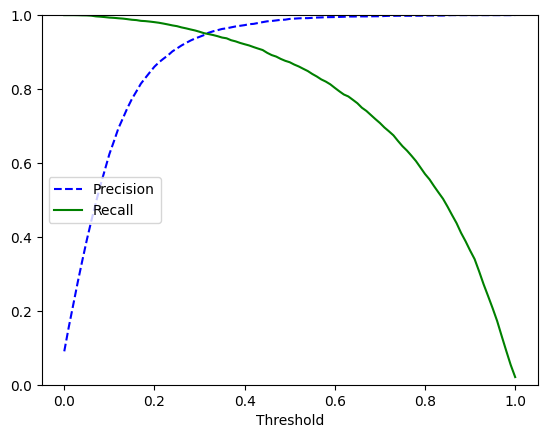

In [68]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

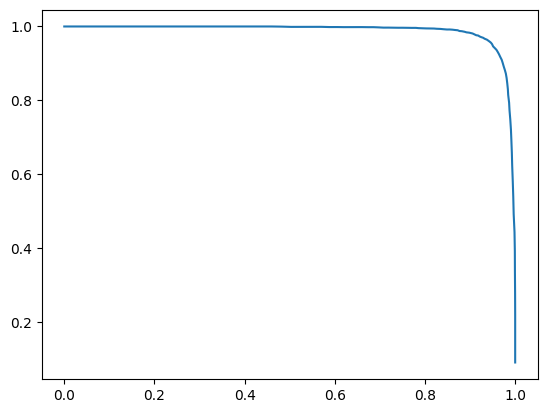

In [69]:
plt.plot(recalls, precisions)

## Multiclass Classification

### Support Vector Machine (SVM) - One vs One

In [70]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train.values, y_train)

SVC()

In [71]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [72]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [73]:
np.argmax(some_digit_scores)

np.int64(5)

In [74]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [75]:
svm_clf.classes_[5]

np.uint8(5)

### One vs Rest Classifier

In [76]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train.values, y_train)

OneVsRestClassifier(estimator=SVC())

In [77]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [78]:
len(ovr_clf.estimators_)

10

### Stochastic Gradient Descent (SGD) Classifier - Multiclass by default

In [79]:
sgd_clf.fit(X_train.values, y_train)

SGDClassifier(random_state=42)

In [80]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [81]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

#### Evaluating the SGD Classifier

In [82]:
cross_val_score(sgd_clf, X_train.values, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

#### Scaling the inputs

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

### Confusion Matrix

In [84]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

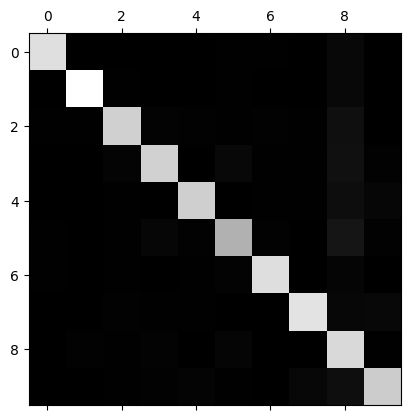

In [85]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [86]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

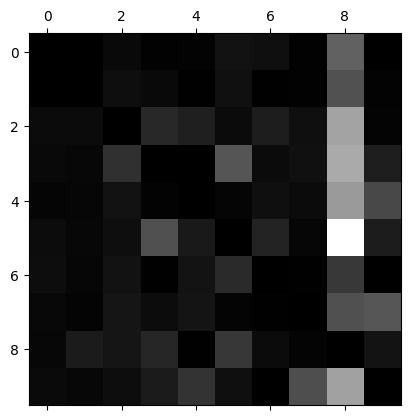

In [87]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

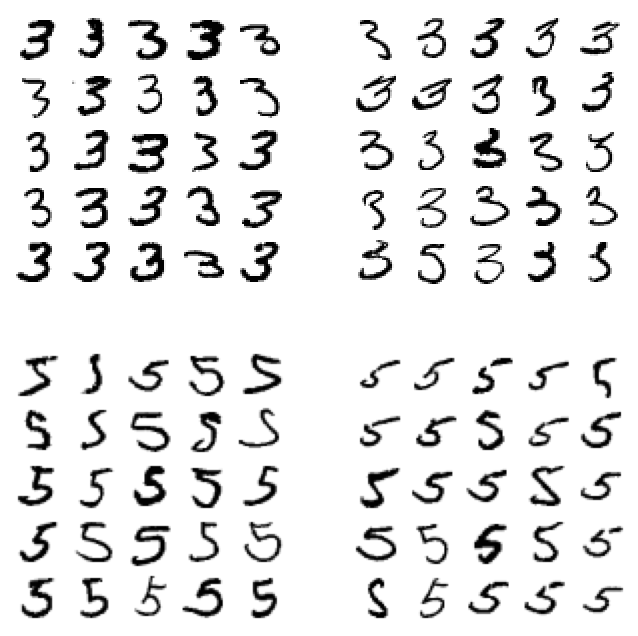

In [91]:
cl_a, cl_b = 3, 5
X_aa = X_train.values[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train.values[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train.values[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train.values[(y_train == cl_b) & (y_train_pred == cl_b)]

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

In [92]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train.values, y_multilabel)

KNeighborsClassifier()

In [93]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [94]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train.values, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

np.float64(0.9764102655606048)

## Multioutput Classification

In [98]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train.values + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test.values + noise
y_train_mod = X_train
y_test_mod = X_test

In [99]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

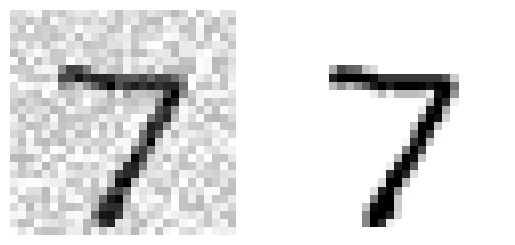

In [102]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod.values[some_index])
plt.show()

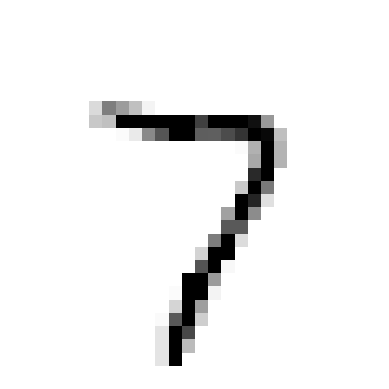

In [103]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## Extra Material

### Other Classifiers

#### Dummy Classifier

In [104]:
from sklearn.dummy import DummyClassifier

dmy_clf = DummyClassifier(strategy='prior')
cross_val_score(dmy_clf, X_train.values, y_train, cv=3, scoring="accuracy")

array([0.11235, 0.11235, 0.1124 ])

In [105]:
dmy_clf = DummyClassifier(strategy='uniform')
cross_val_score(dmy_clf, X_train.values, y_train, cv=3, scoring="accuracy")

array([0.1012 , 0.10185, 0.1003 ])

In [106]:
dmy_clf = DummyClassifier(strategy='stratified')
cross_val_score(dmy_clf, X_train.values, y_train, cv=3, scoring="accuracy")

array([0.09815, 0.1014 , 0.1009 ])

In [107]:
dmy_clf = DummyClassifier(strategy='most_frequent')
cross_val_score(dmy_clf, X_train.values, y_train, cv=3, scoring="accuracy")

array([0.11235, 0.11235, 0.1124 ])

#### KNN Classifier

In [108]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train.values, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=   7.6s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=   7.3s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=   7.4s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=   7.3s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=   7.3s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=   7.2s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=   7.1s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=   7.3s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=   7.1s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=   7.1s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=   7.4s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [109]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [110]:
grid_search.best_score_

np.float64(0.9716166666666666)

In [112]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [113]:
y_knn_pred = knn_clf.predict(X_test)

In [114]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

### Data Augmentation

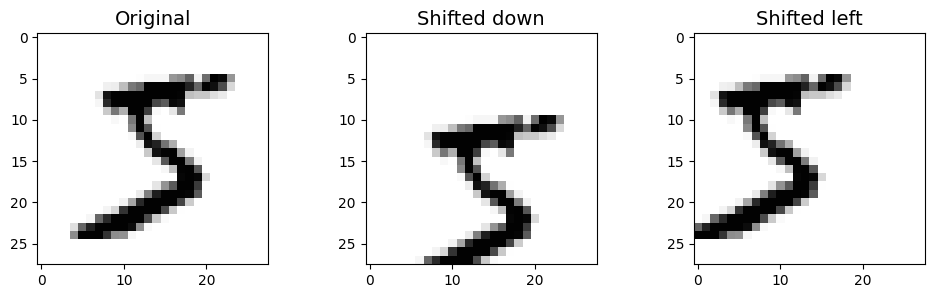

In [165]:
from scipy.ndimage import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

image = X_train.to_numpy()[0]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [166]:
X_train_augmented = [image for image in X_train.values]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train.to_numpy(), y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

    
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [167]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [168]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [169]:
y_knn_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_knn_pred)

C:\Users\Grzegorz\Desktop\um\mnist_classification\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.9763